In [30]:
import os
import pandas as pd

In [98]:
cwd = os.getcwd()
cwd

'/home/connor/code/zulu-tango/news_and_echo_bubbles/notebooks'

In [99]:
parent = os.path.dirname(cwd)
parent

'/home/connor/code/zulu-tango/news_and_echo_bubbles'

In [ ]:
data_folder = os.path.join(parent,"raw_data")
data_folder

In [31]:
left_data_location = os.path.join(data_folder,"braindedleft.csv")
right_data_location = os.path.join(data_folder,"braindedright.csv")

In [100]:
# load in left and right datasets
df_left = pd.read_csv(left_data_location)
df_right = pd.read_csv(left_data_location)

In [101]:
# assign a 0 to left wing articles and a 1 to right wing articles
df_left["ideology"] = 0
df_right["ideology"] = 1

In [102]:
# merge the two datasets
merged_df = pd.concat([df_left,df_right])

In [42]:
merged_df.head(1)

,Unnamed: 0,link,pdate,title,author,text,keywords,tags,compound,neg,neu,pos,polarity,subjectivity,ideology
0,0,https://kindest.com/442355-defend-democracy-to...,NaN,"Defend Democracy Today: Support Fearless, Insi...",[],"While the election has come and gone, the figh...","['reporting', 'come', 'today', 'access', 'chec...",set(),0.8612,0.063,0.819,0.118,0.165589,0.539782,0


In [103]:
# drop unnecessary columns
# we may not want to drop all of these for later analysis, but this is fine for now
merged_df = merged_df.drop(columns = ["Unnamed: 0", "link", "pdate", "title", "author",	"keywords",\
                          "tags", "compound", "neg", "neu", "pos", "polarity", "subjectivity"])

In [57]:
# taking a sample to make testing the model easier
df_sample = merged_df.sample(500)

In [104]:
# check data is balanced between left-wing and right-wing (i.e. c.250 of each class)
df_sample["ideology"].sum()

247

In [53]:
!pip install tensorflow transformers

  Using cached transformers-4.35.2-py3-none-any.whl.metadata (123 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.1 MB/s eta 0:00:00ta 0:00:01
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (14 kB)
  Using cached grpcio-1.59.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached filelock-3.13.1-py3-none-a

In [54]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

2023-11-27 16:04:24.957519: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 16:04:24.962332: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 16:04:24.998899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 16:04:24.998927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 16:04:25.000177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [59]:
df_sample.head()

,text,ideology
214,What You Need To Know About Foreign Interferen...,1
2036,Photo: Gimlet.\n\nUpdate February 25: Reply Al...,1
107,The Republican Party is increasing united arou...,0
932,“From each according to his ability to each ac...,1
1294,The price of electricity would soar under the ...,1


In [105]:
# see what the lengths of the texts are
# need to convert to string first before calculating length as was getting an error that some review text cells were float values and not strings
df_sample["text_length"] = df_sample["text"].apply(lambda x: len(str(x)))

In [75]:
df_sample.head()

,text,ideology,text_length
214,What You Need To Know About Foreign Interferen...,1,6063
2036,Photo: Gimlet.\n\nUpdate February 25: Reply Al...,1,5150
107,The Republican Party is increasing united arou...,0,2400
932,“From each according to his ability to each ac...,1,14795
1294,The price of electricity would soar under the ...,1,5863


In [65]:
import matplotlib.pyplot as plt

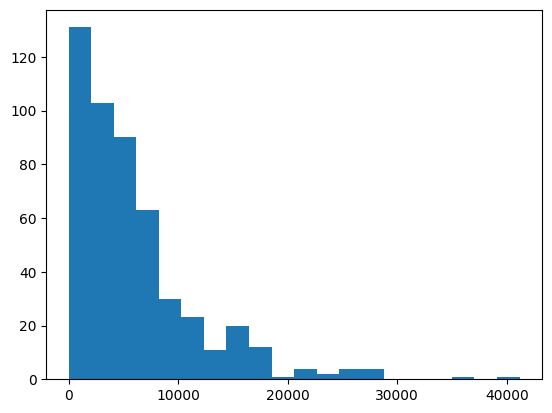

In [106]:
# view histogram of lengths of sample texts
plt.hist(df_sample["text_length"], bins = 20);

In [107]:
# let's say max length is 10,000 from this histogram

In [108]:
# import the tokenizer from DistilBert to tokenize our texts
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [109]:
# example embedding with max length of 10,000
example_embedding = tokenizer(df_sample["text"][0], max_length = 10_000, truncation = True, padding = True)
example_embedding

{'input_ids': [101, 2096, 1996, 2602, 2038, 2272, 1998, 2908, 1010, 1996, 2954, 2005, 2256, 7072, 2003, 2025, 2058, 1012, 2096, 2477, 2298, 2104, 1037, 7226, 2368, 8798, 2061, 2521, 1010, 2009, 1005, 1055, 3154, 6221, 8398, 1005, 1055, 2317, 8986, 1998, 5223, 3993, 17871, 2031, 2275, 7117, 1999, 1996, 3951, 2283, 1012, 1996, 2954, 2005, 2637, 2097, 3613, 2004, 11857, 28514, 1998, 4001, 10643, 2024, 3517, 2000, 3613, 2437, 2009, 3697, 2005, 3533, 7226, 2368, 2000, 3413, 2130, 4235, 2759, 5761, 1012, 1996, 2522, 17258, 1011, 2539, 6090, 3207, 7712, 12058, 2015, 1998, 4841, 3613, 2005, 2074, 6630, 1998, 5245, 2067, 2114, 1996, 4125, 1997, 23779, 1012, 2115, 6691, 2000, 11477, 7159, 2035, 3229, 2097, 5676, 6555, 1010, 7481, 7316, 2043, 2009, 1005, 1055, 2734, 2062, 2084, 2412, 1012, 2096, 6475, 4472, 2070, 1997, 2256, 11727, 1010, 2009, 2987, 1005, 1056, 2272, 2485, 2000, 1996, 4219, 2734, 2000, 3104, 1996, 2047, 1997, 1996, 2088, 2651, 1012, 2490, 11477, 7159, 2035, 3229, 1998, 2113, 2008

In [79]:
import numpy as np

In [110]:
# define our x and y from the dataset
x = df_sample["text"].array
y = df_sample["ideology"].array

In [111]:
# convert x to strings as some are just floats (this should be fixed anyway during pre-processing)
x = [str(x) for row in x]

In [90]:
# using a max_len of 50 here to save time making the encodings
# this took a VERY long time
def construct_encodings(x, tokenizer, max_len=50, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(x, tokenizer)

In [112]:
# turning into a tensor (though I am not sure why)
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, y)

In [92]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(x) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [96]:
N_EPOCHS = 5

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
200/200 [==============================] - 124s 575ms/step - loss: 0.7013 - accuracy: 0.4875
Epoch 2/5
200/200 [==============================] - 116s 581ms/step - loss: 0.6946 - accuracy: 0.5200
Epoch 3/5
200/200 [==============================] - 116s 581ms/step - loss: 0.6986 - accuracy: 0.5000
Epoch 4/5
200/200 [==============================] - 114s 571ms/step - loss: 0.6985 - accuracy: 0.5075
Epoch 5/5
200/200 [==============================] - 118s 589ms/step - loss: 0.6926 - accuracy: 0.5275


In [97]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

50/50 [==============================] - 5s 82ms/step - loss: 0.6898 - accuracy: 0.5600
{'loss': 0.6897661089897156, 'accuracy': 0.5600000023841858}


In [ ]:
# the accuracy is not very good, as only 0.5. Baseline accuracy = 0.5
# could probably improve the accuracy by increasing the length of each article? (currently set to 50 words)
# accuracy will also be increased with better text preprocessing?
# accuracy could also be increased with more epochs (but this takes a long time) - could train on google Colab instead?
# should also set it up so that it uses validation splits in the model compilation?

In [ ]:
## next steps:
# see if there are other models which perform better?